# Grippe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Openhealth_S-Grippal.csv", sep=";")
df.head()

,PERIODE,IAS_brut,IAS_liss�,Incidence_Sentinelles
0,2009-07-01,"1,7","2,2","2,3"
1,2009-07-02,"3,4","2,1","2,3"
2,2009-07-03,"2,1","2,1","2,3"
3,2009-07-04,"1,3",2,"2,3"
4,2009-07-05,"14,2",2,"2,3"


In [2]:
df = df[["PERIODE","IAS_brut"]]
df["IAS_brut"] = df["IAS_brut"].str.replace(",",".").astype(float)
print("Nombre de valeurs manquantes/nulles dans la colonne IAS_brut :")
print(np.sum(df["IAS_brut"] == 0))

Nombre de valeurs manquantes/nulles dans la colonne IAS_brut :
11


In [3]:
for i in df[df["IAS_brut"]==0].index:
    df.loc[i, "IAS_brut"] = np.mean([df.loc[i-1,"IAS_brut"],df.loc[i+1,"IAS_brut"]])

print("Nombre de valeurs manquantes/nulles dans la colonne IAS_brut :")
print(np.sum(df["IAS_brut"] == 0))

Nombre de valeurs manquantes/nulles dans la colonne IAS_brut :
0


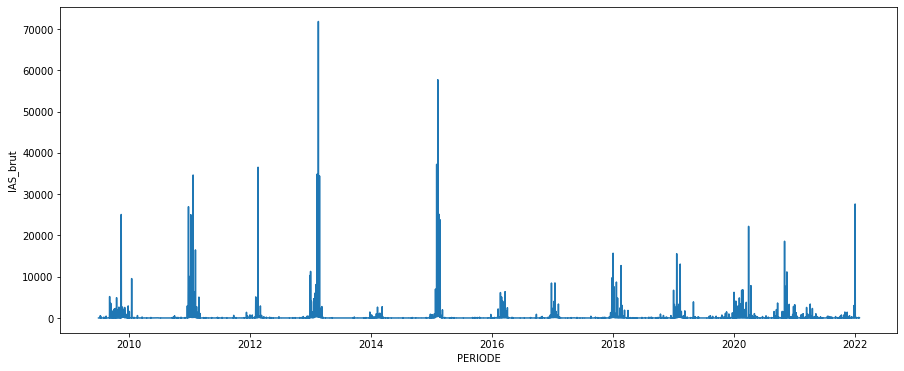

In [4]:
df["PERIODE"] = pd.to_datetime(df["PERIODE"])

plt.figure(figsize=(15,6))
sns.lineplot(data=df,x="PERIODE",y="IAS_brut")
plt.show()

Nous observons des pics épidémiques chaque année durant l'hiver. Il y a - littéralement - de la saisonnalité. Les fortes variations saisonnières nous empêchent de visualiser les variations entre les pics.

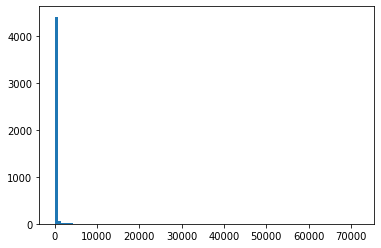

In [5]:
plt.hist(df["IAS_brut"], bins=100)
plt.show()

Nous voyons que la majorité des valeurs sont faibles (situées dans le premier bin de l'histogramme). Cette concentration de valeurs faibles provoque des pics de très grande amplitude et de faible largeur.

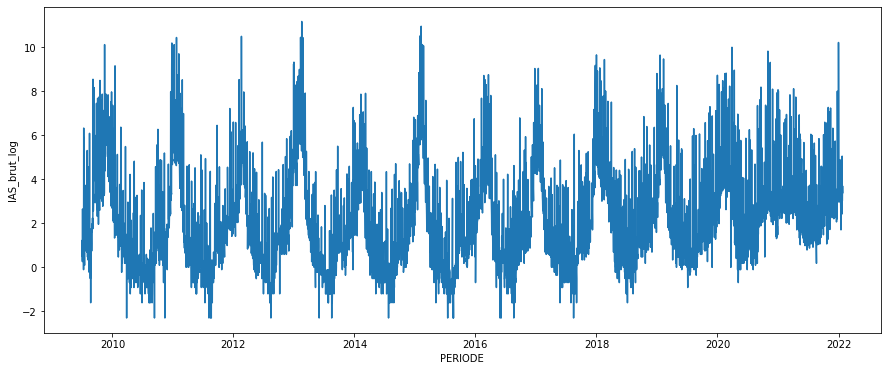

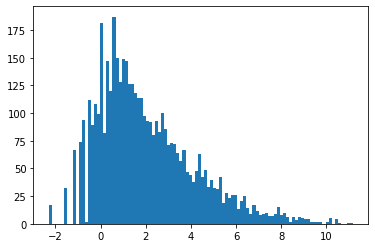

In [6]:
df["IAS_brut_log"] = np.log(df["IAS_brut"])

plt.figure(figsize=(15,6))
sns.lineplot(data=df,x="PERIODE",y="IAS_brut_log")
plt.show()

plt.hist(df["IAS_brut_log"], bins=100)
plt.show()

L'application du logarithme nous permet de mieux visualiser et interpréter les pics épidémiques et leur saisonnalité. L'histogramme montre la tendance vers des valeurs hautes extrêmes - la distribution n'est pas symétrique autour de sa moyenne.

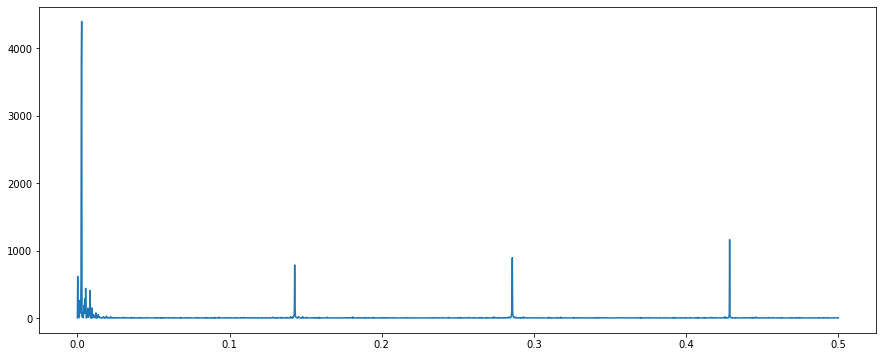

In [7]:
from scipy import signal

periodogram = signal.periodogram(df["IAS_brut_log"])

plt.figure(figsize=(15,6))
sns.lineplot(x=periodogram[0], y=periodogram[1])
plt.show()

Pics significatifs ?

In [8]:
df = df.set_index("PERIODE", drop=True)

In [9]:
df['IAS_brut_yr'] = df['IAS_brut_log'].sub(df['IAS_brut_log'].shift(freq='365 d'))
df.tail()

,IAS_brut,IAS_brut_log,IAS_brut_yr
PERIODE,,,
2022-01-23,156.9,5.055609,1.767207
2022-01-24,20.7,3.030134,0.800119
2022-01-25,38.5,3.650658,0.823345
2022-01-26,40.2,3.693867,0.972572
2022-01-27,29.9,3.397858,0.223980


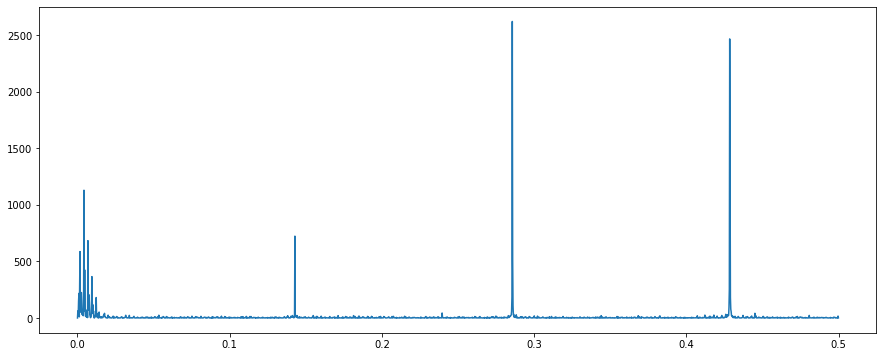

In [10]:
periodogram = signal.periodogram(df["IAS_brut_yr"].dropna())

plt.figure(figsize=(15,6))
sns.lineplot(x=periodogram[0], y=periodogram[1])
plt.show()

RMSE on train : 1.8482590383535384
RMSE on test : 1.4588339205001413
RMSE on train : 1.8151219056909655
RMSE on test : 1.4380003629047322
RMSE on train : 1.7837509968083023
RMSE on test : 1.388313337282429
RMSE on train : 1.7812875053241732
RMSE on test : 1.3913052431759578
RMSE on train : 1.7668033013173479
RMSE on test : 1.3664503285552765
RMSE on train : 1.7666363102173939
RMSE on test : 1.3672421511829707
RMSE on train : 1.762554624342889
RMSE on test : 1.3668969227949603
RMSE on train : 1.7616108238078212
RMSE on test : 1.363857253684708
RMSE on train : 1.7610924001402337
RMSE on test : 1.362576928134844
RMSE on train : 1.7608180665469717
RMSE on test : 1.3620525656576994


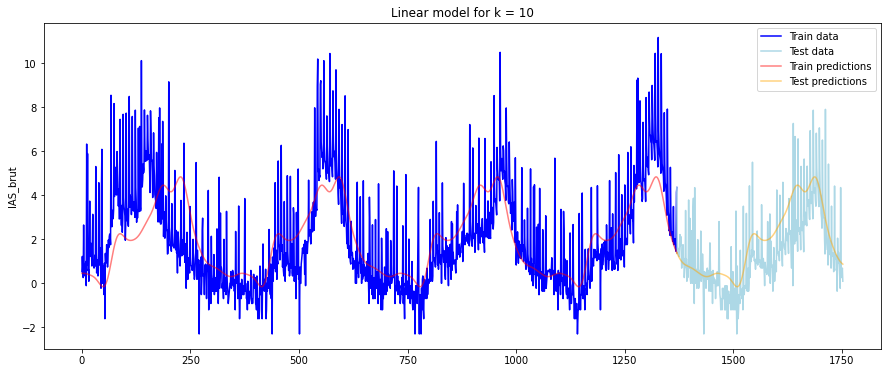

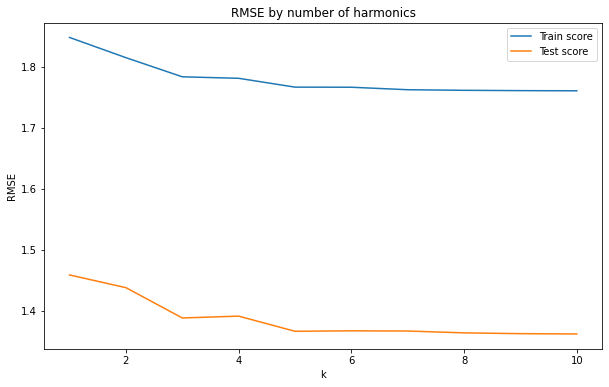

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def generate_cos(x, k=1):
    return np.cos(x*k*(np.pi*2/365))
    
def generate_sin(x, k=1):
    return np.sin(x*k*(np.pi*2/365))

df_reg_train = df.reset_index().loc[:1370,["IAS_brut"]]
df_reg_test = df.reset_index().loc[1370:1752,["IAS_brut"]]

train_scores = list()
test_scores = list()

init_range = range(1,11,1)

for i in init_range:
    df_reg_train[f"cos_harm_{i}"] = df_reg_train.index.to_series().apply(lambda x: generate_cos(x, i))
    df_reg_train[f"sin_harm_{i}"] = df_reg_train.index.to_series().apply(lambda x: generate_sin(x, i))
    df_reg_test[f"cos_harm_{i}"] = df_reg_test.index.to_series().apply(lambda x: generate_cos(x, i))
    df_reg_test[f"sin_harm_{i}"] = df_reg_test.index.to_series().apply(lambda x: generate_sin(x, i))

    X_train, y_train = df_reg_train.iloc[:,1:], df_reg_train.iloc[:,0].apply(np.log)
    X_test, y_test = df_reg_test.iloc[:,1:], df_reg_test.iloc[:,0].apply(np.log)

    model = LinearRegression()
    model.fit(X_train, y_train)
    
    #print("R2 on train :",model.score(X_train, y_train))
    #print("R2 on test :",model.score(X_test, y_test))
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_scores.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
    test_scores.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))

    print("RMSE on train :",train_scores[-1])
    print("RMSE on test :",test_scores[-1])

plt.figure(figsize=(15,6))
sns.lineplot(x=X_train.index,y=y_train, label="Train data", color="blue")
sns.lineplot(x=X_test.index,y=y_test, label="Test data", color="lightblue")
sns.lineplot(x=X_train.index,y=y_pred_train, label="Train predictions", color="red", alpha=.5)
sns.lineplot(x=X_test.index,y=y_pred_test, label="Test predictions", color="orange", alpha=.5)
plt.legend()
plt.title(f"Linear model for k = {i}")
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(x=init_range,y=train_scores,label="Train score")
sns.lineplot(x=init_range,y=test_scores,label="Test score")
plt.ylabel("RMSE")
plt.xlabel("k")
plt.legend()
plt.title("RMSE by number of harmonics")
plt.show()

# Trafic internet

In [12]:
df = pd.read_csv("lbl-tcp-3.tcp",sep=" ",header=None,names=["time","var1","var2","var3","var4","var5"]).sort_values("time")
df["bin"] = pd.cut(df["time"], bins=[x*10 for x in range(721)])
df = df.groupby("bin").count()[["time"]].reset_index(drop=True)
df.head()

,time
0,1614
1,1729
2,3220
3,1767
4,1891


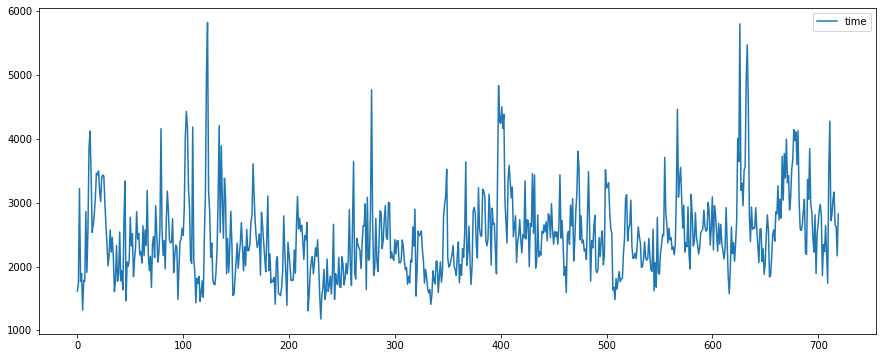

In [13]:
plt.figure(figsize=(15,6))
sns.lineplot(data=df)
plt.show()

In [14]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

aics = list()
bics = list()
mse = list()

p_range = range(1,11)

for p in p_range:
    model = ARIMA(df["time"],order=(p,0,0))
    model_fit = model.fit()
    print("AIC :",model_fit.aic)
    print("BIC :",model_fit.bic)
    aics.append(model_fit.aic)
    bics.append(model_fit.bic)
    tempscores = list()
    for t in range(5):
        train, test = df.iloc[:int(720/2+t*(720/2)/5),:], df.iloc[int(720/2+t*(720/2)/5):int(720/2+(t+1)*(720/2)/5),:]
        #display(train.tail())
        #display(test.head())
        model = ARIMA(train,order=(p,0,0))
        model_fit = model.fit()
        preds = model_fit.predict(test.index[0],test.index[-1])
        tempscores.append(mean_squared_error(test["time"],preds))
    mse.append(np.mean(tempscores))
    print("Cross-validated MSE :",mse[-1])

AIC : 11043.491130589508
BIC : 11057.228884225538
Cross-validated MSE : 471930.6820160498
AIC : 11040.557445733451
BIC : 11058.874450581492
Cross-validated MSE : 472238.24535420054
AIC : 11041.390650708277
BIC : 11064.286906768328
Cross-validated MSE : 473506.8702188491
AIC : 11037.237720026827
BIC : 11064.713227298887
Cross-validated MSE : 474452.83144922444
AIC : 11039.091100851534
BIC : 11071.145859335606
Cross-validated MSE : 475687.7665176441
AIC : 11040.441385053804
BIC : 11077.075394749885
Cross-validated MSE : 475568.8907473261
AIC : 11042.316742168841
BIC : 11083.530003076932
Cross-validated MSE : 475160.3010006089
AIC : 11043.309370846688
BIC : 11089.101882966788
Cross-validated MSE : 475656.6979748456
AIC : 11045.319733604916
BIC : 11095.691496937026
Cross-validated MSE : 475506.8156385853
AIC : 11047.305319048792
BIC : 11102.256333592914
Cross-validated MSE : 475407.4634856791


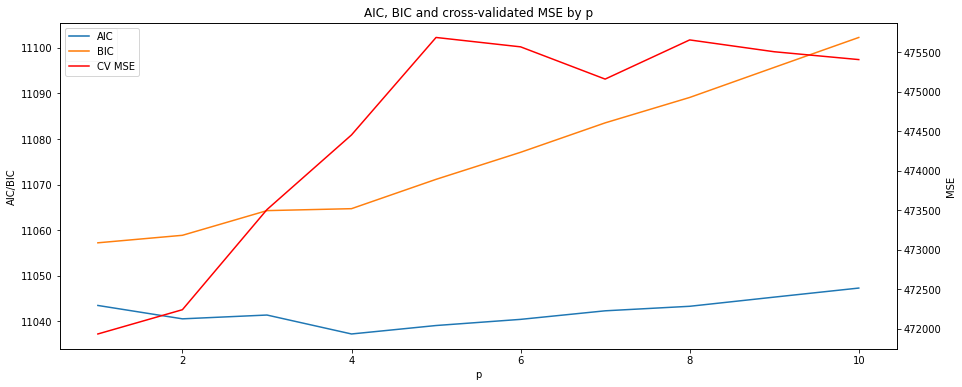

In [15]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
l1 = sns.lineplot(x=p_range, y=aics, label="AIC", ax=ax)
l2 = sns.lineplot(x=p_range, y=bics, label="BIC", ax=ax)
ax.set_ylabel("AIC/BIC")
ax.set_xlabel("p")
ax2 = plt.twinx()
l3 = sns.lineplot(x=p_range, y=mse, color="red", label="CV MSE", ax=ax2)
ax2.set_ylabel("MSE")
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.title("AIC, BIC and cross-validated MSE by p")
plt.show()

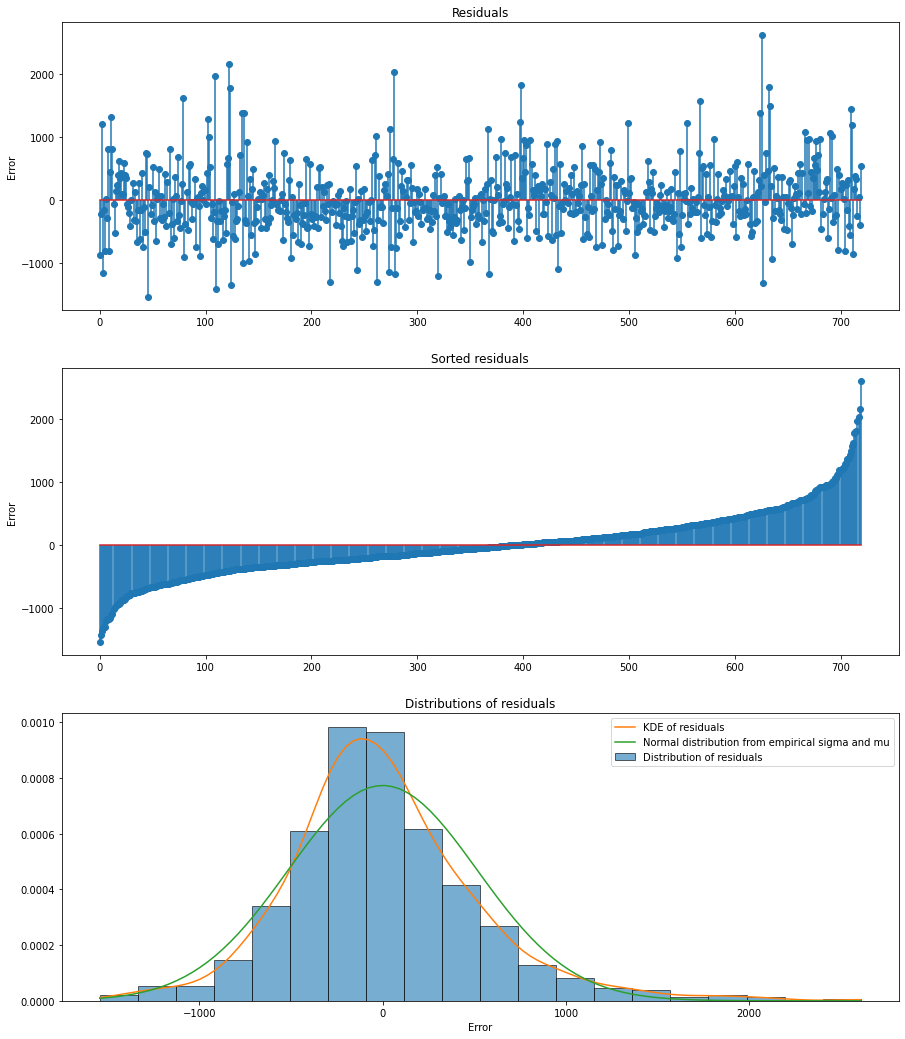

In [16]:
import scipy.stats as stats

model = ARIMA(df["time"],order=(1,0,0))
model_fit = model.fit()
preds = model_fit.predict(df.index[0],df.index[-1])
res = df["time"]-preds
fig = plt.figure(figsize=(15,18))
ax = fig.add_subplot(3,1,1)
ax.stem(res)
ax.set_ylabel("Error")
ax.set_title("Residuals")
ax2 = fig.add_subplot(3,1,2)
ax2.stem(np.sort(res))
ax2.set_ylabel("Error")
ax2.set_title("Sorted residuals")
ax3 = fig.add_subplot(3,1,3)
ax3.hist(res,label="Distribution of residuals",bins=20,density=True,alpha=.6,edgecolor="black")
kde = stats.gaussian_kde(res)
x = np.linspace(np.min(res),np.max(res),100)
ax3.plot(x,kde(x),label="KDE of residuals")
mu = np.mean(res)
sigma = np.std(res)
ax3.plot(x, stats.norm.pdf(x, mu, sigma), label="Normal distribution from empirical sigma and mu")
ax3.set_xlabel("Error")
ax3.set_title("Distributions of residuals")
plt.legend()
plt.show()

Les résidus semblent suivre une distribution normale. Cependant, on remarque une légère sur-représentation d'erreurs légèrement faibles et une tendance aux grandes erreurs positives supérieures à la loi normale.

# Southern Oscillation Index

In [17]:
df = pd.read_csv("soi.tsv",sep="\t",header=None).T.dropna()
df.columns = ["x"]
df.head()

,x
0,1.537160
1,0.922168
2,-0.104204
3,-0.291903
4,-0.658745


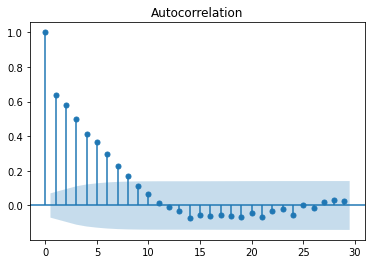

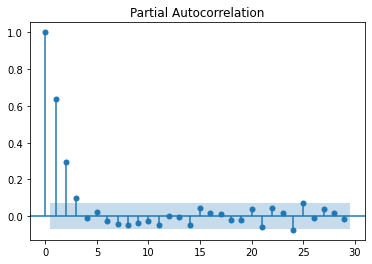

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df)
plt.show()
plot_pacf(df)
plt.show()

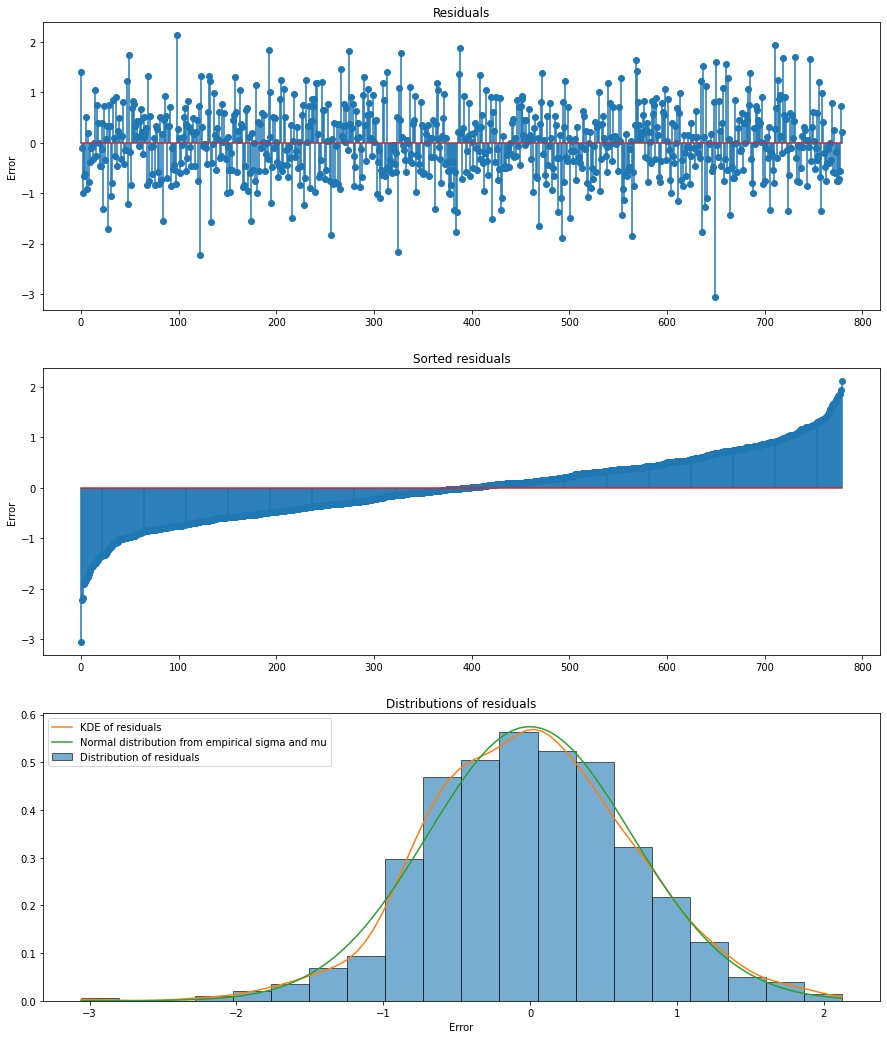

In [19]:
import scipy.stats as stats

model = ARIMA(df["x"],order=(4,0,0))
model_fit = model.fit()
preds = model_fit.predict(df.index[0],df.index[-1])
res = df["x"]-preds
fig = plt.figure(figsize=(15,18))
ax = fig.add_subplot(3,1,1)
ax.stem(res)
ax.set_ylabel("Error")
ax.set_title("Residuals")
ax2 = fig.add_subplot(3,1,2)
ax2.stem(np.sort(res))
ax2.set_ylabel("Error")
ax2.set_title("Sorted residuals")
ax3 = fig.add_subplot(3,1,3)
ax3.hist(res,label="Distribution of residuals",bins=20,density=True,alpha=.6,edgecolor="black")
kde = stats.gaussian_kde(res)
x = np.linspace(np.min(res),np.max(res),100)
ax3.plot(x,kde(x),label="KDE of residuals")
mu = np.mean(res)
sigma = np.std(res)
ax3.plot(x, stats.norm.pdf(x, mu, sigma), label="Normal distribution from empirical sigma and mu")
ax3.set_xlabel("Error")
ax3.set_title("Distributions of residuals")
plt.legend()
plt.show()

In [20]:
model_fit.polynomial_ar

array([ 1.        , -0.42253912, -0.25300889, -0.10344769,  0.01130433])

[12.860237752979073, 11.51099566169943, 10.407238404009675, 9.491451147475626, 8.72221754436767, 8.069068957302797, 7.509165048007512, 7.025096124135464, 6.603393048324657, 6.2334952095504725, 5.907022001158414, 5.617249638030513, 5.358729540315848, 5.127006001917266, 4.918404585895099, 4.729871628871153, 4.5588511668381475, 4.403189594863609, 4.261061113099481, 4.1309089151405525, 4.011398414930495, 3.9013797635278187, 3.799857595572791, 3.7059664469839593, 3.61895065464052, 3.538147823115722, 3.4629751491284133, 3.3929180497740643, 3.327520658971843, 3.266377847413025, 3.209128491512063, 3.1554497714951206, 3.105052321540421, 3.0576760885851724, 3.013086783115216, 2.97107282652548, 2.931442716674754, 2.894022746969443, 2.8586550253991163, 2.825195748954886, 2.7935136962122677, 2.7634889068832873, 2.735011522098107, 2.7079807632692936, 2.6823040307848247, 2.6578961065989186, 2.634678447146538, 2.612578554981538, 2.59152941919741, 2.571469016087963, 2.5523398626875755, 2.53408861683314

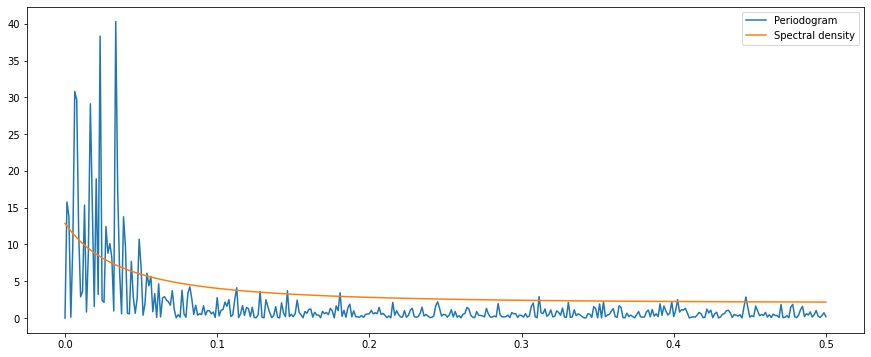

In [22]:
periodogram = signal.periodogram(df["x"])

def spectraldensity(x):
    return sigma*(np.abs(1-np.sum([phi*np.exp(complex(-2*np.pi)*k*x) for k, phi in enumerate(model_fit.params[1:-1])])))**-2

plt.figure(figsize=(15,6))
sns.lineplot(x=periodogram[0], y=periodogram[1], label="Periodogram")
x = np.linspace(0,.5,100)
print(list(map(spectraldensity,x)))
sns.lineplot(x=x, y=list(map(spectraldensity,x)), label="Spectral density")
plt.show()